# Questão 3

a) Implemente e treine um autoencoder utilizando o dataset Fashion-MNIST, disponível em:
https://www.kaggle.com/datasets/zalando-research/fashionmnist. O objetivo deste exercício é
compreender como esse tipo de rede neural é capaz de aprender representações comprimidas
de dados e realizar reconstruções a partir dessas representações. O autoencoder pode ser
construído utilizando apenas camadas densas (fully connected) ou, alternativamente, camadas
convolucionais e deconvolucionais.
Após o treinamento, selecione 10 imagens do conjunto de teste e utilize o modelo treinado para
gerar as reconstruções correspondentes. Apresente os resultados visualmente, exibindo lado a
lado as imagens originais e suas respectivas reconstruções, de modo que seja possível avaliar
qualitativamente o desempenho do autoencoder. Apresente também a curva do erro médio ao
longo do treinamento.

(b) Complete o exercício da questão 3(a) adicionando ruído aleatório às imagens de entrada,
com o objetivo de treinar um denoising autoencoder. Após o treinamento, utilize as 10 imagens
selecionadas na questão anterior (com o ruído aplicado) e apresente os resultados
visualmente, exibindo lado a lado as imagens originais e suas respectivas reconstruções. Avalie
qualitativamente o desempenho do modelo em remover o ruído e preservar as características
das imagens originais.

## a)

In [32]:
import kagglehub
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, Cropping2D, Conv2DTranspose
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from random import randint
from skimage.util import random_noise
import pandas as pd
import numpy as np
from PIL import Image

In [2]:
# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fashionmnist


In [3]:
# Carrega os dados de treinamento
train_df = pd.read_csv(path + '/fashion-mnist_train.csv')

# Carrega os dados de teste
test_df = pd.read_csv(path + '/fashion-mnist_test.csv')

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

In [6]:
X_train = X_train / 255
X_test = X_test / 255

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [8]:
X_train = X_train.reshape(-1, 784)
X_val = X_val.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

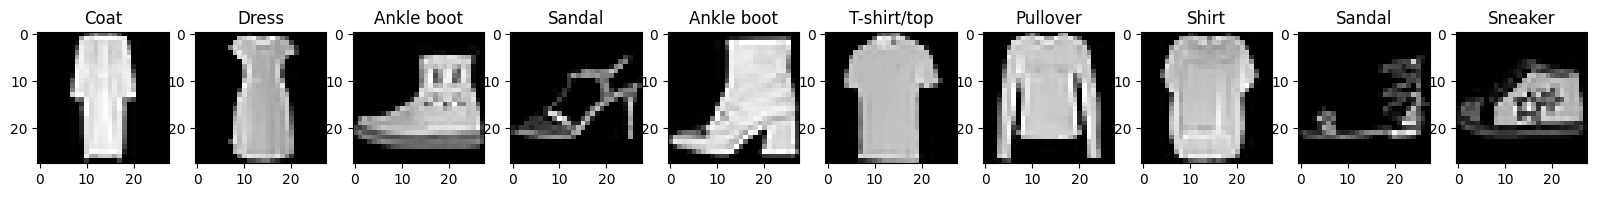

In [9]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    # Reshape the image before displaying
    image = X_train[i].reshape(28, 28)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(labeldict[y_train[i]])

In [10]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1500)                │       1,177,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1000)                │       1,501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 500)                 │           5,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1000)                │         501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1500)                │       1,501,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 784)                 │       1,176,784 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,368,794 (24.30 MB)

 Trainable params: 6,368,794 (24.30 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(X_train, X_train, epochs=20, batch_size=2048, validation_data=(X_val, X_val), callbacks=[early_stopping])

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.1262 - mae: 0.2536 - val_loss: 0.0719 - val_mae: 0.2063
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0685 - mae: 0.1975 - val_loss: 0.0509 - val_mae: 0.1607
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0476 - mae: 0.1529 - val_loss: 0.0399 - val_mae: 0.1314
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0391 - mae: 0.1289 - val_loss: 0.0364 - val_mae: 0.1213
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0365 - mae: 0.1210 - val_loss: 0.0343 - val_mae: 0.1158
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0337 - mae: 0.1156 - val_loss: 0.0311 - val_mae: 0.1107
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.0305 - mae: 0.1093 - val_loss: 0.0282 - val_mae: 0.1039
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0283 - mae: 0.1049 - val_loss: 0.0263 - val_mae: 0.1006
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.0260 - mae: 

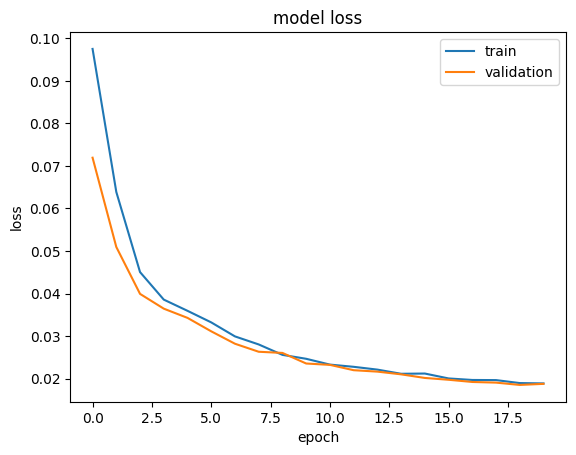

In [14]:
# plot da curva do erro médio
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [15]:
preds = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


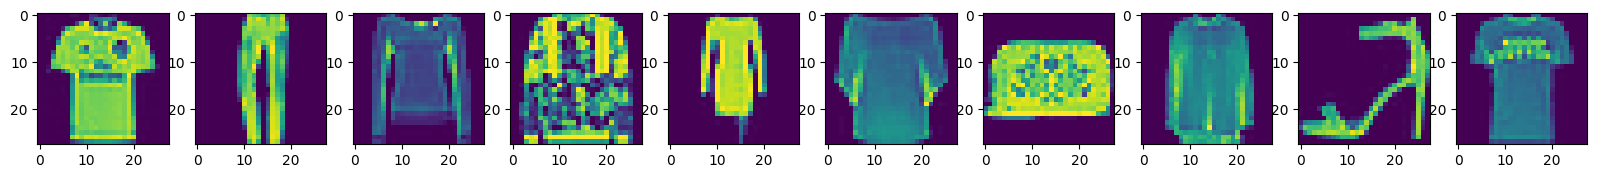

In [16]:
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(X_test[i].reshape(28, 28))
plt.show()

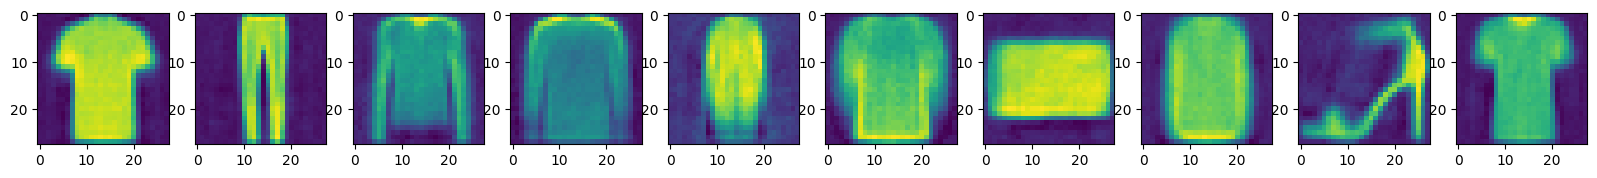

In [17]:
f, ax = plt.subplots(1,10)
f.set_size_inches(20, 20)
for i in range(10):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

## b)

In [18]:
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

X_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

In [19]:
X_train = X_train / 255
X_test = X_test / 255

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [21]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [22]:
# Adicionar ruído gaussiano ao conjunto de treino
train_images_noisy = [random_noise(img, mode='gaussian', var=0.01) for img in X_train]

# Adicionar ruído gaussiano ao conjunto de validação
val_images_noisy = [random_noise(img, mode='gaussian', var=0.01) for img in X_val]

# Adicionar ruído gaussiano ao conjunto de teste
test_images_noisy = [random_noise(img, mode='gaussian', var=0.01) for img in X_test]

In [23]:
train_images_noisy = np.array(train_images_noisy).reshape(-1, 28, 28, 1)
val_images_noisy = np.array(val_images_noisy).reshape(-1, 28, 28, 1)
test_images_noisy = np.array(test_images_noisy).reshape(-1, 28, 28, 1)

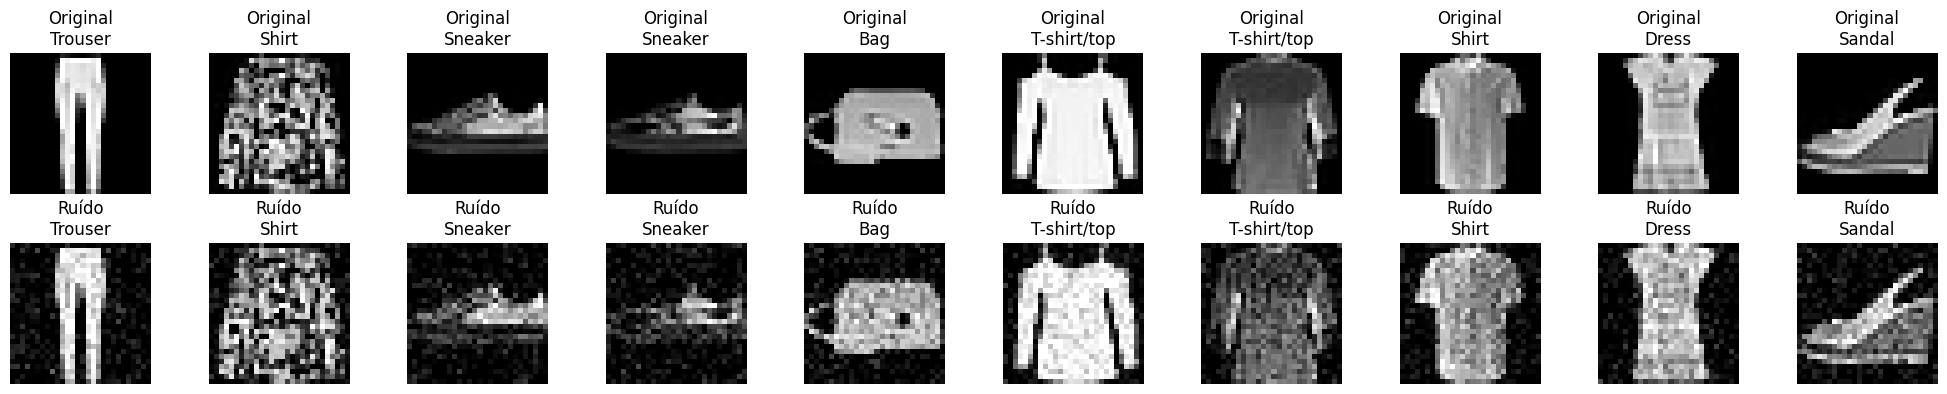

In [24]:
fig, ax = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    # Linha 1: Imagens originais
    ax[0, i].imshow(X_train[i], cmap='gray')
    ax[0, i].set_title(f"Original\n{labeldict[y_train[i]]}")
    ax[0, i].axis('off')

    # Linha 2: Imagens com ruído
    ax[1, i].imshow(train_images_noisy[i], cmap='gray')
    ax[1, i].set_title(f"Ruído\n{labeldict[y_train[i]]}")
    ax[1, i].axis('off')

plt.tight_layout()
plt.show()

In [40]:
## input layer
input_layer = Input(shape=(28,28, 1))

## encoding architecture
encode_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encode_layer1 = MaxPool2D((2, 2))(encode_layer1)

encode_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encode_layer1)
encode_layer2 = MaxPool2D((2, 2))(encode_layer2)

encode_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encode_layer2)

## latent view
latent_view   = MaxPool2D((2, 2), padding='same')(encode_layer3)

## decoding architecture
decode_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decode_layer1 = UpSampling2D((2, 2))(decode_layer1)

decode_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decode_layer1)
decode_layer2 = UpSampling2D((2, 2))(decode_layer2)

decode_layer3 = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(decode_layer2)

output_layer = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(decode_layer3)
output_layer = Cropping2D(cropping=((2, 2), (2, 2)))(output_layer)  # Crops from (32x32) to (28x28)

model = Model(input_layer, output_layer)

In [41]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 7, 7, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 4, 4, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_14 (UpSampling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_15 (UpSampling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 32, 32, 1)           │             577 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_1 (Cropping2D)            │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,761 (194.38 KB)

 Trainable params: 49,761 (194.38 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Treino com input ruído → target limpo
model.fit(
    train_images_noisy,
    X_train,
    epochs=20,
    batch_size=128,
    validation_data=(val_images_noisy, X_val),
    callbacks=[early_stopping]
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 247s 653ms/step - loss: 0.0308 - val_loss: 0.0189
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 238s 635ms/step - loss: 0.0183 - val_loss: 0.0164
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 275s 671ms/step - loss: 0.0159 - val_loss: 0.0146
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 249s 635ms/step - loss: 0.0145 - val_loss: 0.0141
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 246s 656ms/step - loss: 0.0136 - val_loss: 0.0129
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 252s 629ms/step - loss: 0.0130 - val_loss: 0.0124
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 269s 649ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 260s 643ms/step - loss: 0.0119 - val_loss: 0.0116
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 242s 645ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 262s 646ms/step - loss: 0.0112 - val_loss: 0.0120
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 241s 644ms/step - loss: 0.0110 - val_loss: 0.0111
Epoch 12

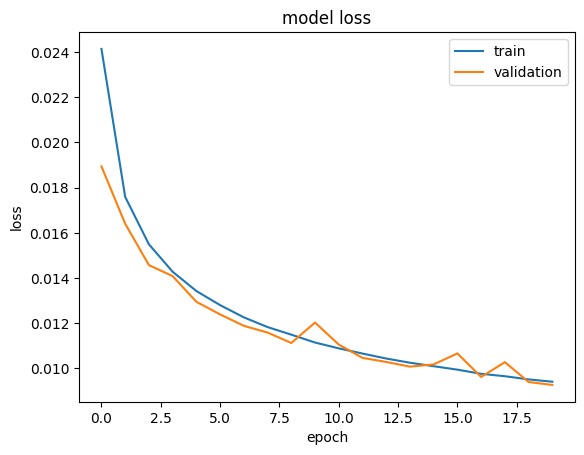

In [48]:
# plot da curva do erro médio
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [49]:
preds_denoising = model.predict(test_images_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step


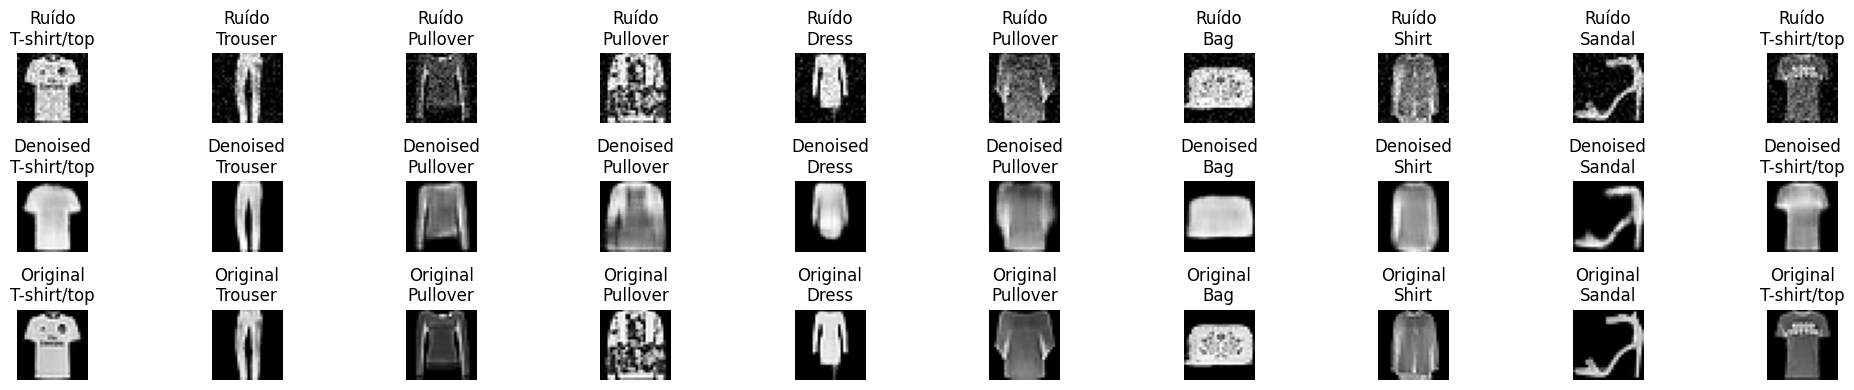

In [52]:
fig, ax = plt.subplots(3, 10, figsize=(20, 4))

for i in range(10):
    # Linha 1: Imagens com ruído
    ax[0, i].imshow(test_images_noisy[i], cmap='gray')
    ax[0, i].set_title(f"Ruído\n{labeldict[y_test[i]]}")
    ax[0, i].axis('off')

    # Linha 2: Imagens reconstruídas
    ax[1, i].imshow(preds_denoising[i], cmap='gray')
    ax[1, i].set_title(f"Denoised\n{labeldict[y_test[i]]}")
    ax[1, i].axis('off')

    # Linha 3: Imagens originais
    ax[2, i].imshow(X_test[i], cmap='gray')
    ax[2, i].set_title(f"Original\n{labeldict[y_test[i]]}")
    ax[2, i].axis('off')

plt.tight_layout()
plt.show()